# OOD training

## Import + utilisation de CUDA

Utilisation de torch, torchvision, torch_ood

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from pytorch_ood.detector import EnergyBased
from pytorch_ood.utils import OODMetrics, fix_random_seed
import cv2 as cv
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim
from torch.utils.data import ConcatDataset
import pandas as pd
import random
from sklearn.metrics import roc_auc_score

fix_random_seed(123)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"

/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Pl

# Affichage d'images

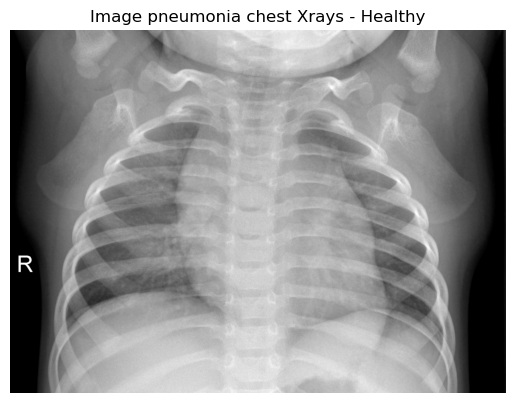

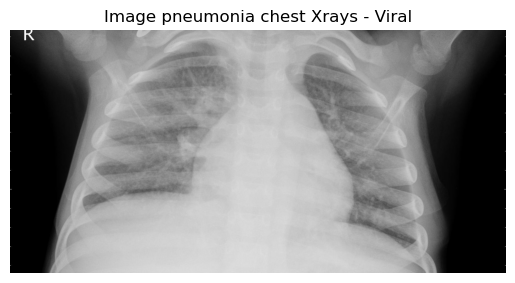

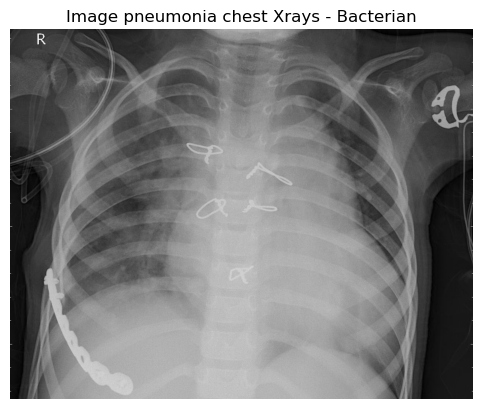

In [2]:
pneumonia_image_path = 'data/dataset_Healthy/OOD/2/normal_1.jpeg'
pneumonia_img = cv.imread(pneumonia_image_path)
pneumonia_img_rgb = cv.cvtColor(pneumonia_img, cv.COLOR_BGR2RGB)

pneumonia_virus_path = 'data/dataset_Viral/OOD/2/virus_3.jpeg'
pneumonia_virus_img = cv.imread(pneumonia_virus_path)
pneumonia_virus_rgb = cv.cvtColor(pneumonia_virus_img, cv.COLOR_BGR2RGB)

pneumonia_b_path = 'data/dataset_Bacterian/OOD/2/bacteria_1.jpeg'
pneumonia_b_img = cv.imread(pneumonia_b_path)
pneumonia_b_rgb = cv.cvtColor(pneumonia_b_img, cv.COLOR_BGR2RGB)

plt.imshow(pneumonia_img_rgb)
plt.title('Image pneumonia chest Xrays - Healthy')
plt.axis('off')
plt.show()
plt.imshow(pneumonia_virus_img)
plt.title('Image pneumonia chest Xrays - Viral')
plt.axis('off')
plt.show()
plt.imshow(pneumonia_b_img)
plt.title('Image pneumonia chest Xrays - Bacterian')
plt.axis('off')
plt.show()

## Transformations

Pour générer nos images, nous créeront un dataset par transformation que nous souhaitons appliquer, puis nous concaténeront les datasets.

In [3]:
size = 512

# Original
trans = v2.Compose([
    v2.ToTensor(),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

# Honrizontal Flip
trans_hflip = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

# Invert
trans_invert = v2.Compose([
    v2.ToTensor(),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.RandomInvert(),
    v2.Resize((size,size)),
])

# Rotate 90°
trans_rot_90 = v2.Compose([
    v2.ToTensor(),
    v2.RandomRotation(90),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

# Rotate 270°
trans_rot_270 = v2.Compose([
    v2.ToTensor(),
    v2.RandomRotation(270),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])


# Grayscale
trans_gray = v2.Compose([
    v2.ToTensor(),
    v2.RandomGrayscale(),
    v2.Normalize([0.5]*3, [0.5]*3),    
    v2.Resize((size,size)),
])

# Gaussian blur
trans_gaus_blur = v2.Compose([
    v2.ToTensor(),
    v2.GaussianBlur(kernel_size=1),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])


trans_sat = v2.Compose([
    v2.ToTensor(),
    v2.RandomPhotometricDistort(saturation=(1.5,1.5),p=1),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

trans_bright = v2.Compose([
    v2.ToTensor(),
    v2.ColorJitter(saturation=2),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

trans_contrast = v2.Compose([
    v2.ToTensor(),
    v2.ColorJitter(contrast=2),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

trans_solar = v2.Compose([
    v2.ToTensor(),
    v2.RandomSolarize(threshold=0.3),
    v2.Normalize([0.5]*3, [0.5]*3),
    v2.Resize((size,size)),
])

trans_list_aug=[trans_gray,trans_hflip,trans_invert,trans_rot_90,trans_rot_270]
trans_list_dis=[trans_gaus_blur,trans_sat,trans_bright,trans_contrast,trans_solar]

/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# Définition du batch size, sélection du modèle, définition de fonctions

In [4]:
import os
# Création d'un dataframe pour compiler les résultats
df_compil = pd.DataFrame(columns=["model", "dataset", "validation_results", "test_results", "metrics"])


In [5]:
# Viral for virus OOD, Bacterian for bacteria OOD, Healthy for healthy OOD
model_name = "Healthy"

print("Model " + model_name + " Training")
batch_size =  2 ** 6
print("batch_size = " + str(batch_size))

def get_datasets(case_name="Viral"):
    datasets_ID_aug_list = []
    datasets_OOD_aug_list = []
    datasets_ID_dis_list = []
    datasets_OOD_dis_list = []

    for tr in trans_list_aug:
        datasets_ID_aug_list.append(ImageFolder(root="data/dataset_"+case_name+"/ID",transform=tr))
        datasets_OOD_aug_list.append(ImageFolder(root="data/dataset_"+case_name+"/OOD",transform=tr))

    for tr in trans_list_dis:
        datasets_ID_dis_list.append(ImageFolder(root="data/dataset_"+case_name+"/ID",transform=tr))
        datasets_OOD_dis_list.append(ImageFolder(root="data/dataset_"+case_name+"/OOD",transform=tr))

    dataset_ID_un = ImageFolder(root="data/dataset_"+case_name+"/ID",transform=trans)
    dataset_OOD_un = ImageFolder(root="data/dataset_"+case_name+"/OOD",transform=trans)
    dataset_ID_aug = ConcatDataset(datasets_ID_aug_list)
    dataset_OOD_aug = ConcatDataset(datasets_OOD_aug_list)
    dataset_ID_dis = ConcatDataset(datasets_ID_dis_list)
    dataset_OOD_dis = ConcatDataset(datasets_OOD_dis_list)

    return ("dataset_un", dataset_ID_un,dataset_OOD_un),("dataset_aug", dataset_ID_aug,dataset_OOD_aug),("dataset_dis", dataset_ID_dis,dataset_OOD_dis)

import torch.nn as nn

def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    lost_function_compil = []
    train_acc_compil = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        # Phase d'entraînement
        optimizer.zero_grad()   
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        lost_function_compil.append(epoch_loss)
        train_acc_compil.append(epoch_acc)

        #print(f'Epoch {epoch}/{num_epochs - 1}, Train_Loss: {epoch_loss:.6f}, Train_Accuracy: {epoch_acc:.6f}')
    return model, lost_function_compil, train_acc_compil

# Evaluation du modèle sur les ensembles de test ID et OOD
def evaluate_model(model, loader, criterion, str="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        inputs, labels = next(iter(loader))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        #print(f'labels on {str}', labels)
        #print(f'predicted on {str}', predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total

    print(f'{str} Loss: {epoch_loss:.6f}, {str} Accuracy: {epoch_acc:.6f}')
    return(epoch_acc)

# Fonction pour évaluer le modèle
def evaluate_OOD(model, test_loader_in, test_loader_out):
    detector = EnergyBased(model)
    metrics = OODMetrics()

    # Evaluation pour IN
    for x, y in test_loader_in:
        metrics.update(detector(x.to(device)), y)

    # Evaluation pour OOD
    for x, y in test_loader_out:
        y = torch.ones_like(y) * -1 
        metrics.update(detector(x.to(device)), y)

    return metrics.compute()

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_predictions(data_loader, model, n_forward_passes=50):
    model.eval()
    enable_dropout(model)
    
    all_preds = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.cuda()  # Assuming you have a GPU available
            preds = []
            for _ in range(n_forward_passes):
                output = model(data)
                preds.append(output.unsqueeze(0))
            all_preds.append(torch.cat(preds))
    
    return torch.cat(all_preds)

def calculate_uncertainty(mc_preds):
    # Calculate mean and variance
    mean_preds = mc_preds.mean(dim=0)
    var_preds = mc_preds.var(dim=0)
    # Calculate entropy as a measure of uncertainty
    entropy = -torch.sum(mean_preds * torch.log(mean_preds + 1e-5), dim=-1)
    return entropy


Model Healthy Training
batch_size = 64


# Lancement du modèle

/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change fro

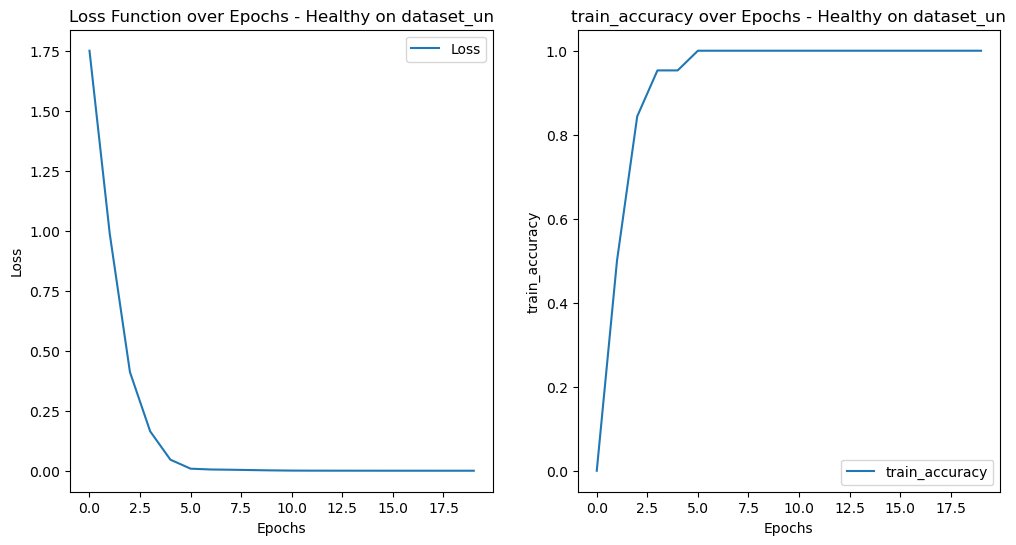

Evaluating on validation set:


/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation Loss: 3.081141, Validation Accuracy: 0.312500


Evaluating on test set:


/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Loss: 3.846258, Test Accuracy: 0.300000




/home/tmathubert/.conda/envs/datascience/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AUROC: {'AUROC': 0.3973333239555359, 'AUPR-IN': 0.19380389153957367, 'AUPR-OUT': 0.7592436075210571, 'FPR95TPR': 0.8199999928474426}


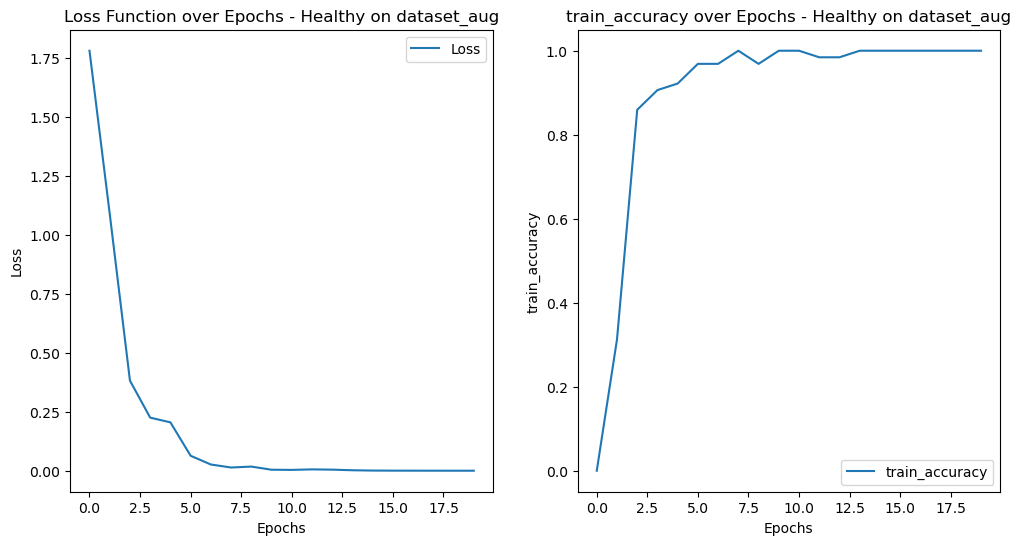

Evaluating on validation set:
Validation Loss: 0.469720, Validation Accuracy: 0.833333


Evaluating on test set:
Test Loss: 1.085137, Test Accuracy: 0.666667


AUROC: {'AUROC': 0.7002333402633667, 'AUPR-IN': 0.4478435516357422, 'AUPR-OUT': 0.8427623510360718, 'FPR95TPR': 0.9466666579246521}


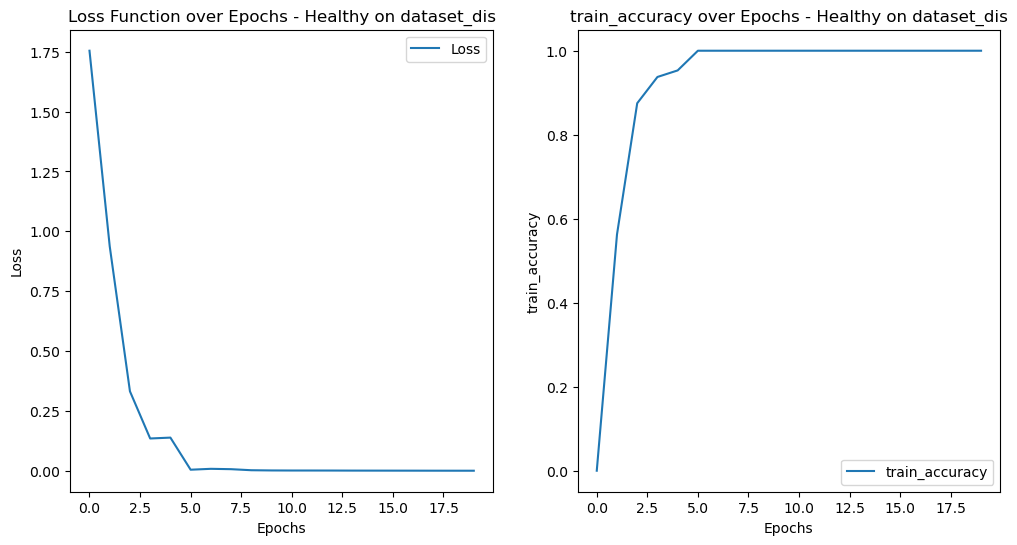

Evaluating on validation set:
Validation Loss: 0.659331, Validation Accuracy: 0.729167


Evaluating on test set:
Test Loss: 1.513646, Test Accuracy: 0.566667


AUROC: {'AUROC': 0.7407000064849854, 'AUPR-IN': 0.4817756414413452, 'AUPR-OUT': 0.8787167072296143, 'FPR95TPR': 0.8133333325386047}


In [6]:
datasets = get_datasets(model_name)

for dataset_name,dataset_ID,dataset_OOD in datasets:

    indices_ID = random.sample(range(len(dataset_ID)), 300)
    sub_ID = torch.utils.data.Subset(dataset_ID,indices_ID)
    
    indices_OOD = random.sample(range(len(dataset_OOD)), 100)
    sub_OOD = torch.utils.data.Subset(dataset_OOD,indices_OOD)
    
    train_indices, test_indices = train_test_split(range(len(sub_ID)), test_size=0.2)
    train_indices, valid_indices = train_test_split(train_indices, test_size=0.2)

    # Creating SubsetRandomSampler instances for train, validation, and test sets
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Creating DataLoader instances for train, validation, and test sets using the samplers
    train_loader = DataLoader(sub_ID, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    valid_loader = DataLoader(sub_ID, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
    test_loader = DataLoader(sub_ID, batch_size=batch_size, sampler=test_sampler, num_workers=4)

    # Using ResNet18 pretrained + optimal weights
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
    # Définition du critère (CrossEntropy) et de l'optimiseur (Adam)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Entraîner le modèle
    num_epochs = 20
    trained_model, lost_function_compil, train_acc_compil = train_model(model, train_loader, criterion, optimizer, num_epochs)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Loss Function over Epochs - {model_name} on {dataset_name}')
    ax1.legend()

    ax2.plot(range(len(train_acc_compil)), train_acc_compil, label='train_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('train_accuracy')
    ax2.set_title(f'train_accuracy over Epochs - {model_name} on {dataset_name}')
    ax2.legend()
    #plt.savefig(f"Loss and Train accuracy curves - {model_name} on {dataset_name}")
    plt.show()

    # Évaluation sur l'ensemble de validation ID
    print("Evaluating on validation set:")
    valid_accuracy = evaluate_model(trained_model, valid_loader, criterion, str="Validation")
    print("\n")

    # Évaluation sur l'ensemble de test ID
    print("Evaluating on test set:")
    test_accuracy = evaluate_model(trained_model, test_loader, criterion, str="Test")
    print("\n")

    # Évaluation des performances OOD (utilisation d'un détecteur de Monte-Carlo)
    test_loader_in = DataLoader(sub_ID, batch_size=batch_size, shuffle=False)
    test_loader_out = DataLoader(sub_OOD, batch_size=batch_size, shuffle=False)

    metrics = evaluate_OOD(model, test_loader_in, test_loader_out)

    #id_mc_preds = get_monte_carlo_predictions(test_loader_in, model)
    #ood_mc_preds = get_monte_carlo_predictions(test_loader_out, model)

    # Calculate uncertainties for ID and OOD datasets
    #id_uncertainties = calculate_uncertainty(id_mc_preds)
    #ood_uncertainties = calculate_uncertainty(ood_mc_preds)

    # Create labels for ID (0) and OOD (1)
    #id_labels = torch.zeros(id_uncertainties.size(0))
    #ood_labels = torch.ones(ood_uncertainties.size(0))

    # Concatenate uncertainties and labels
    #all_uncertainties = torch.cat([id_uncertainties, ood_uncertainties]).cpu().numpy()
    #all_labels = torch.cat([id_labels, ood_labels]).cpu().numpy()

    #metrics = roc_auc_score(all_labels, all_uncertainties)
    print(f'AUROC: {metrics}')

    new_data = pd.DataFrame({
                            'model': [f'{model_name}'],
                            'dataset': [f'{dataset_name}'],
                            'validation_results': [f'{valid_accuracy}'],
                            'test_results': [f'{test_accuracy}'],
                            'metrics': [f'{metrics}']
    })

    df_compil = pd.concat([df_compil, new_data], ignore_index=True)

In [7]:
#df_compil.to_csv("results.csv",index=False)